In [1]:
# This is boilerplate code to correctly setup the settings to for notebook.
import os, sys
for root, dirs, files in os.walk(os.getcwd()):
    # print(root)

    if "pi0-analysis" in root.split("/"):
        pypath = root.split("pi0-analysis")[0] + "/pi0-analysis/analysis"
        print(pypath)
        break

sys.path.insert(0, pypath)

from python.analysis.NotebookUtils import init_notebook
%init_notebook

/home/bhuller/new_python_test/xs_analysis//pi0-analysis/analysis
/home/bhuller/new_python_test/xs_analysis//pi0-analysis/analysis
env: PYTHONPATH=/home/bhuller/new_python_test/xs_analysis//pi0-analysis/analysis


In [2]:
from python.analysis import Master, Plots, BeamParticleSelection, vector
import numpy as np
import awkward as ak

In [3]:
mc = Master.Data("/data/dune/common/PDSPAnalyzer_Ntuples/PDSPProd4a_MC_2GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03.root", nTuple_type=Master.Ntuple_Type.PDSP, target_momentum=2)
mask = BeamParticleSelection.BeamTriggerSelection(mc, use_beam_inst = False)
mc.Filter([mask], [mask])

f=<Array [True, True, True, True, ..., True, True, False] type='141548 * bool'>


In [4]:
data = Master.Data("/data/dune/common/PDSPAnalyzer_Ntuples/PDSPProd4_data_2GeV_reco2_ntuple_v09_42_03_01.root", nTuple_type = Master.Ntuple_Type.PDSP, target_momentum = 1)
mask = BeamParticleSelection.BeamTriggerSelection(data, use_beam_inst = True)
data.Filter([mask], [mask])

f=<Array [False, False, False, ..., False, False, False] type='1349399 * bool'>


# Space Charge Map

In [186]:
from dataclasses import dataclass
import scipy.interpolate as interp

def center(edges):
    return (edges[1:] + edges[:-1]) / 2

class SCEMap:
    x : np.ndarray # coords
    y : np.ndarray
    z : np.ndarray

    vx : interp.RegularGridInterpolator # values of the displacements
    vy : interp.RegularGridInterpolator
    vz : interp.RegularGridInterpolator

    dx : interp.RegularGridInterpolator # interpolator to get values from (derived from v)
    dy : interp.RegularGridInterpolator
    dz : interp.RegularGridInterpolator

    def __init__(self, filename : str, interpolation_method : str = "slinear"):
        pos_x = None
        pos_x = None
        y = None
        z = None
        pos_v = {}
        neg_v = {}

        with Master.uproot.open(filename) as file:
            for k in file.keys():
                name = k.lower().split("_") # should be prefix_unit_component_pos/neg
                if "fwd" in name[0]: continue # recofwd applies space chage correction in reco (data) space?, reco bkwd in true (mc) space? unclear what this means. 
                # if name[1] == "displacement":
                #     pref = ""
                # else:
                #     pref = "e" # electric field
                if name[1] != "displacement":
                    continue # skip electric field maps for now

                v = file[k].to_numpy()
                print(name[2], k)

                if "pos" in name[3]:
                    pos_x = v[1]
                    pos_v[name[2]] = v[0]
                else:
                    neg_x = v[1]
                    neg_v[name[2]] = v[0]

                y = center(v[2])
                z = center(v[3])
        x = np.concat([center(neg_x), abs(center(pos_x))], axis = 0)
        v = {k : np.concat([neg_v[k], pos_v[k]], axis = 0) for k in pos_v}

        self.x = x
        self.y = y
        self.z = z

        for k in v:
            setattr(self, f"v{k}", v[k])
            setattr(self, f"d{k}", interp.RegularGridInterpolator((self.x, self.y, self.z), v[k], method = interpolation_method, bounds_error = False, fill_value = None))
        return

    def get_value_interp(self, interpolator : interp.RegularGridInterpolator, p : ak.Record):
        return interpolator([p.x, p.y, p.z]) # this is a physical position rather than an index as the interpolate map is based on the TPC dimensions

    def get_value(self, pos : vector.vector): # single value
        return vector.vector(
            self.get_value_interp(self.dx, pos),
            self.get_value_interp(self.dy, pos),
            self.get_value_interp(self.dz, pos)
        )

    @Master.timer
    def get_value_record(self, pos : vector.vector): # intended for arrays of vectors
        v = {"x" : [], "y" : [], "z" : []}
        for i in pos:
            tmp = np.array([i.x, i.y, i.z]).T # restructure data into numpy compatible format
            v["x"].append(self.dx(tmp))
            v["y"].append(self.dy(tmp))
            v["z"].append(self.dz(tmp))
        v = ak.Array(v)
        return v

In [183]:
sce_map = SCEMap("/home/bhuller/SCE_DataDriven_180kV_v4.root")

x RecoBkwd_Displacement_X_Neg;1
y RecoBkwd_Displacement_Y_Neg;1
z RecoBkwd_Displacement_Z_Neg;1
x RecoBkwd_Displacement_X_Pos;1
y RecoBkwd_Displacement_Y_Pos;1
z RecoBkwd_Displacement_Z_Pos;1


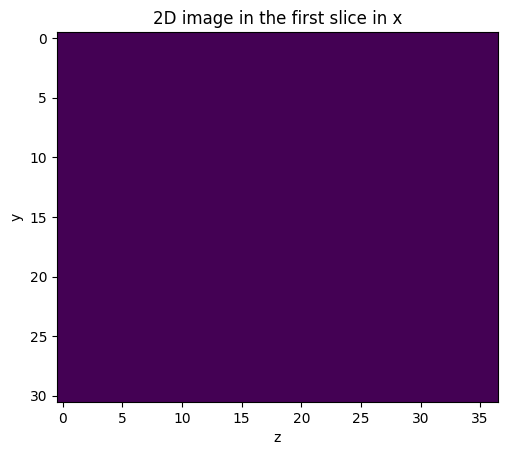

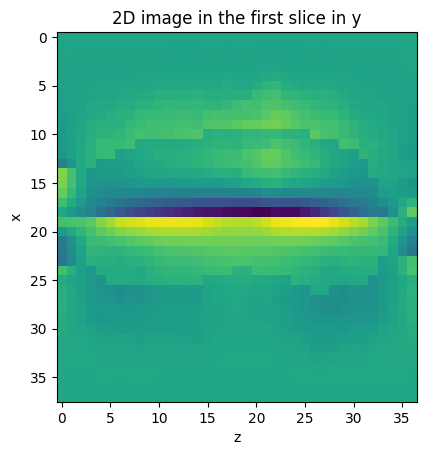

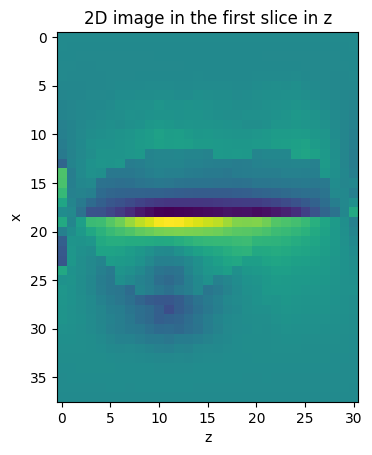

In [171]:
def plot_slice(m, xlabel, ylabel, title):
    Plots.plt.figure()
    Plots.plt.imshow(m)
    Plots.plt.xlabel(xlabel)
    Plots.plt.ylabel(ylabel)
    Plots.plt.title(title)
    return

plot_slice(sce_map.vx[0, :, :], "z", "y", "2D image in the first slice in x")
plot_slice(sce_map.vx[:, 0, :], "z", "x", "2D image in the first slice in y")
plot_slice(sce_map.vx[:, :, 0], "z", "x", "2D image in the first slice in z")

(31, 38, 37)


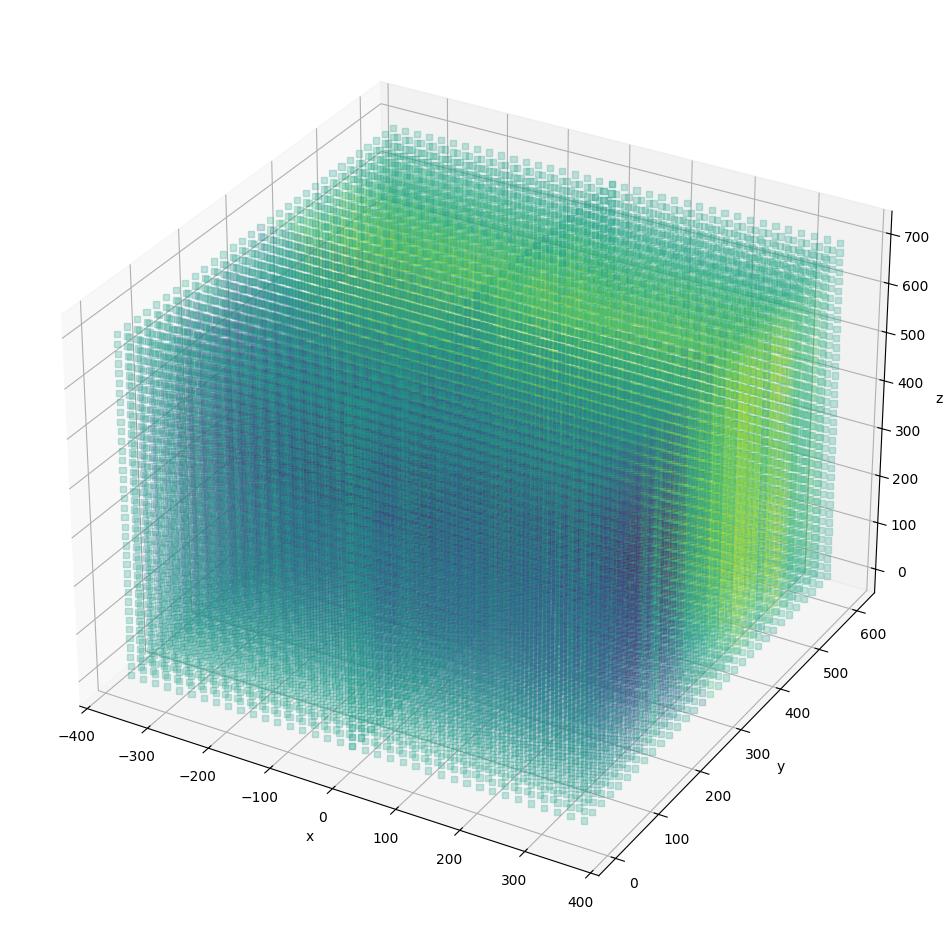

In [172]:
mg = np.meshgrid(sce_map.x, sce_map.y, sce_map.z)
print(mg[0].shape)

# and plot everything
ax = Plots.plt.figure(figsize=(16,12)).add_subplot(projection='3d')
ax.scatter(mg[0], mg[1], mg[2],c = sce_map.vx, alpha = 0.25, marker = "s")
# ax.scatter(x[1][coord[0]], x[2][coord[1]], x[3][coord[2]], alpha = 1, marker = "x", c = "red")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
Plots.plt.show()

In [ ]:
ind = 5
pos = mc.recoParticles.beam_endPos[ind]
pos_sce = mc.recoParticles.beam_endPos_SCE[ind]

print(f"{pos=}")
print(f"{pos_sce=}")

c = sce_map.get_value(pos)

print("actual displacements:")
print({i : float(pos[i] - pos_sce[i]) for i in ["x", "y", "z"]})

print("displacements from map (note that negative map displacement needs to be inverted):")
print(c)


pos=<Record {x: -47.2, y: 397, z: 114} type='{x: float64, y: float64, z: float64}'>
pos_sce=<Record {x: -50.5, y: 399, z: 104} type='{x: float64, y: float64, z: float64}'>
actual displacements:
{'x': 3.274250030517578, 'y': -2.53875732421875, 'z': 10.736549377441406}
displacements from map (note that negative map displacement needs to be inverted):
[{x: -3.32, y: 2.45, z: -10.3}]


In [ ]:
def test_sce(sample : Master.Data, is_mc : bool):
    def mask(dim, low, high):
        return (sample.recoParticles.beam_endPos[dim] > low) & (sample.recoParticles.beam_endPos[dim] < high)

    fvx = [min(center(sce_map.x)), max(center(sce_map.x))]
    fvy = [min(center(sce_map.y)), max(center(sce_map.y))]
    fvz = [min(center(sce_map.z)), max(center(sce_map.z))]

    m = (sample.recoParticles.beam_endPos_SCE.x != -999) & (sample.recoParticles.beam_endPos.x != -999) & mask("x", *fvx) & mask("y", *fvy) & mask("z", *fvz)

    sce_reference = sample.recoParticles.beam_endPos_SCE[m] # to compare to

    corrections = sce_map.get_value_record(sample.recoParticles.beam_endPos[m])
    corrections = vector.vector(*[ak.flatten(corrections[i]) for i in ["x", "y", "z"]])

    corrected_positions = vector.add(sample.recoParticles.beam_endPos[m], corrections)


    reco = sample.recoParticles.beam_endPos[m]

    Plots.PlotHistComparison([sce_reference.x, corrected_positions.x], labels = ["ntuple", "manual correction"], xlabel="x (cm)")
    Plots.PlotHistComparison([sce_reference.y, corrected_positions.y], labels = ["ntuple", "manual correction"], xlabel="y (cm)")
    Plots.PlotHistComparison([sce_reference.z, corrected_positions.z], labels = ["ntuple", "manual correction"], xlabel="z (cm)")

    deltas = {i : sce_reference[i] - corrected_positions[i] for i in ["x", "y", "z"]}
    mus = {k : np.mean(v) for k, v in deltas.items()}
    rms = {k : np.std(v) for k, v in deltas.items()}

    Plots.PlotHistComparison(list(deltas.values()), labels = [f"{k} | mu:{mus[k]:.2f} (cm)| rms:{rms[k]:.2f} (cm)" for k in deltas], x_range=(-2.5, 2.5), xlabel="deltas (cm)")

    if is_mc:
        true = ak.flatten(sample.trueParticles.endPos[sample.trueParticles.number == 1][m])
        Plots.PlotHistComparison([true.x, reco.x, sce_reference.x], labels = ["true", "reco", "reco_sce"], xlabel="x (cm)")
        Plots.PlotHistComparison([true.z, reco.z, sce_reference.z], labels = ["true", "reco", "reco_sce"], xlabel="y (cm)")
        Plots.PlotHistComparison([true.y, reco.y, sce_reference.y], labels = ["true", "reco", "reco_sce"], xlabel="z (cm)")

        ref_delta = vector.sub(sce_reference, true)
        cor_delta = vector.sub(corrected_positions, true)

        Plots.PlotHistComparison([ref_delta.x, cor_delta.x], labels = ["ntuple", "manual correction"], xlabel="reco - true in x (cm)")
        Plots.PlotHistComparison([ref_delta.x, cor_delta.y], labels = ["ntuple", "manual correction"], xlabel="reco - true in y (cm)")
        Plots.PlotHistComparison([ref_delta.x, cor_delta.z], labels = ["ntuple", "manual correction"], xlabel="reco - true in z (cm)")
    return


'get_value_record' executed in 13.2788s

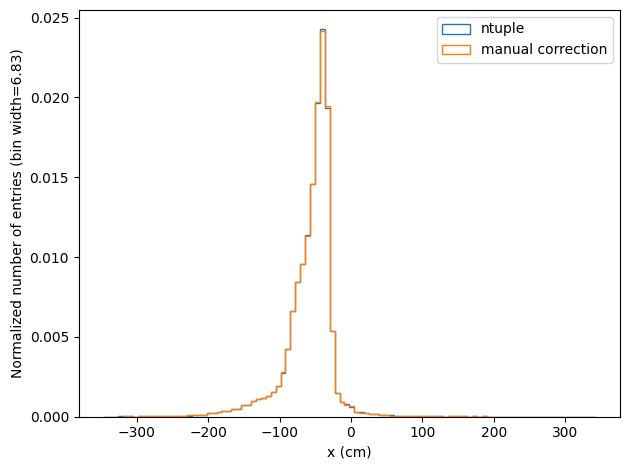

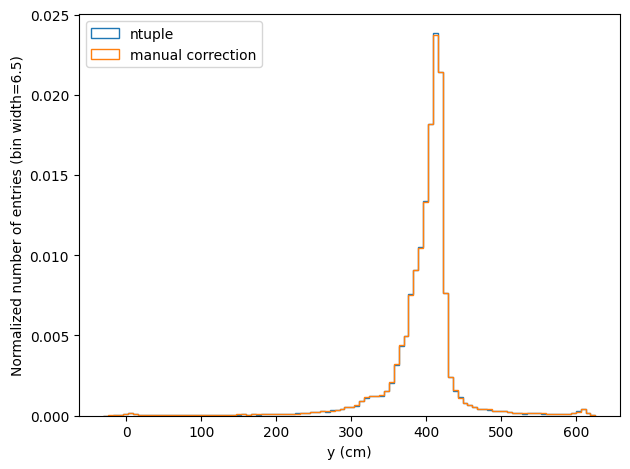

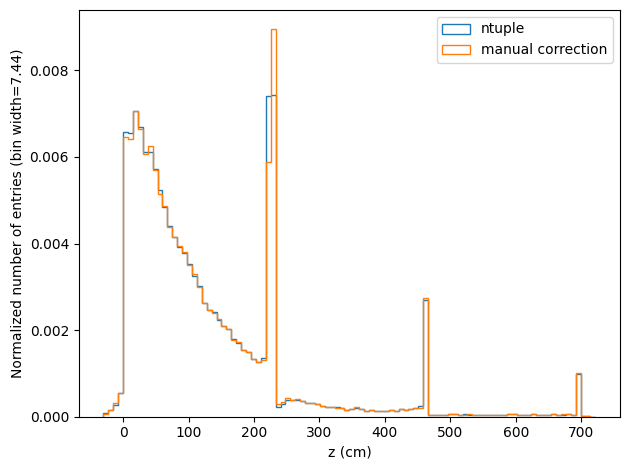

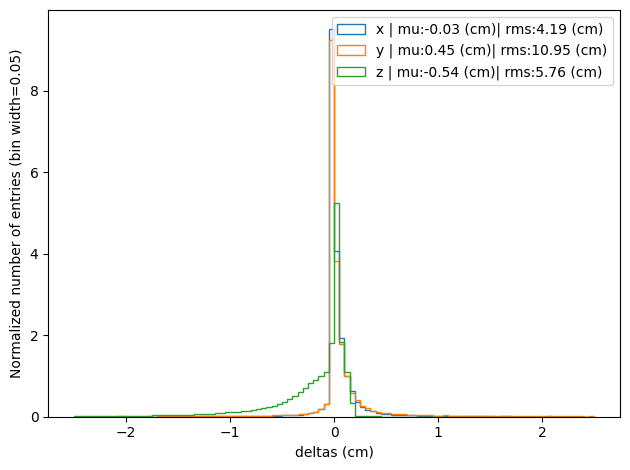

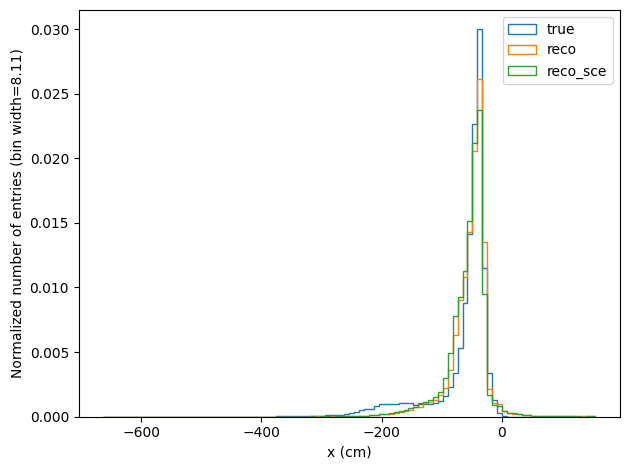

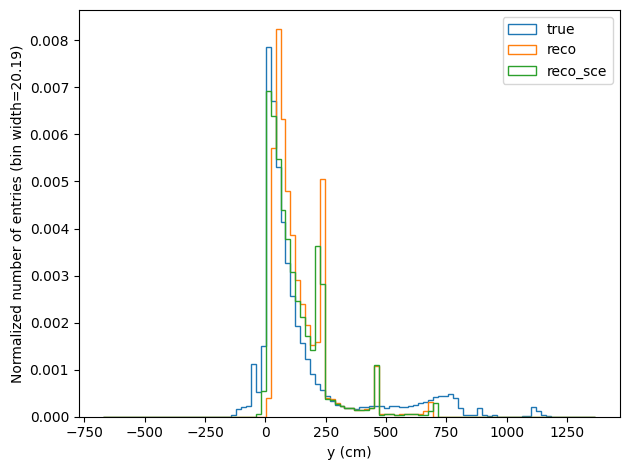

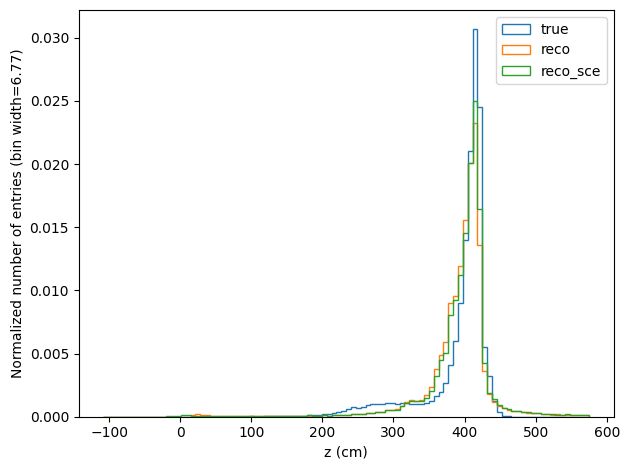

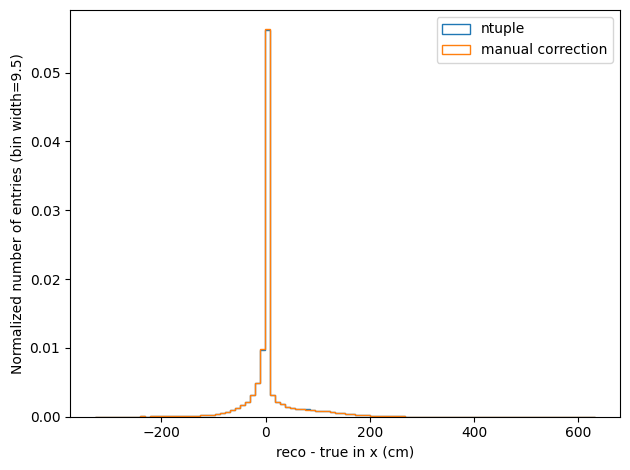

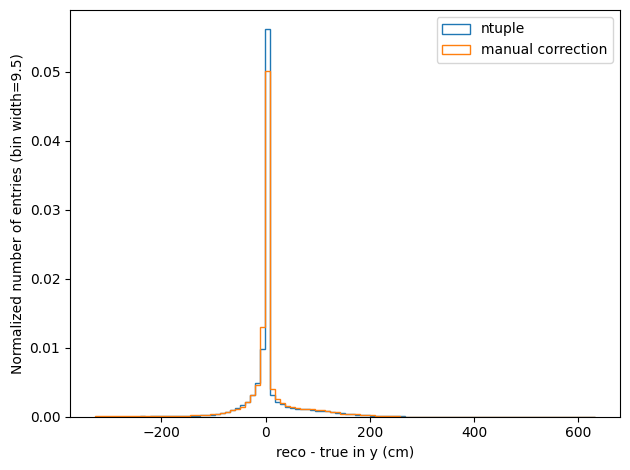

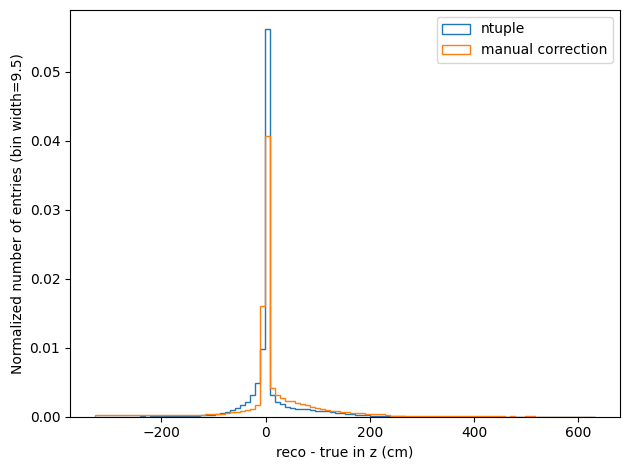

In [217]:
test_sce(mc, True)

'get_value_record' executed in 34.3626s

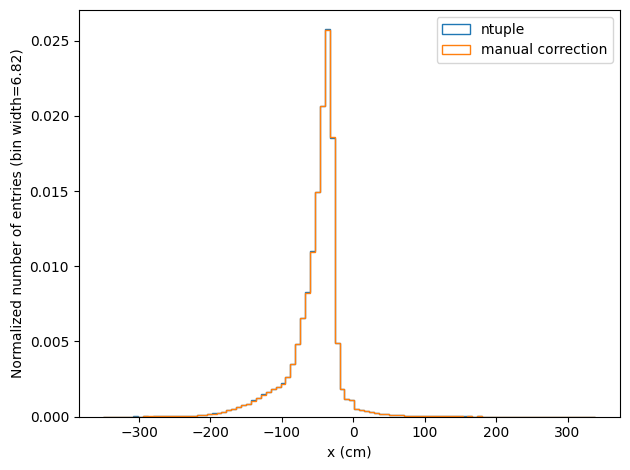

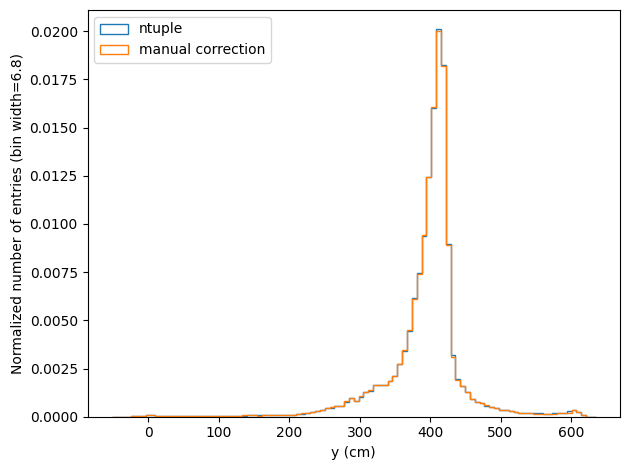

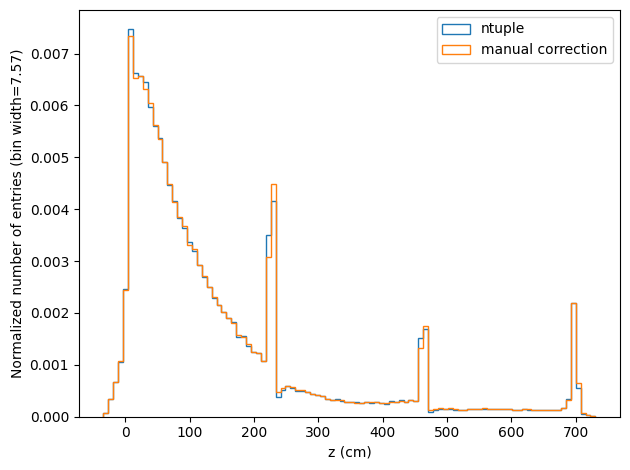

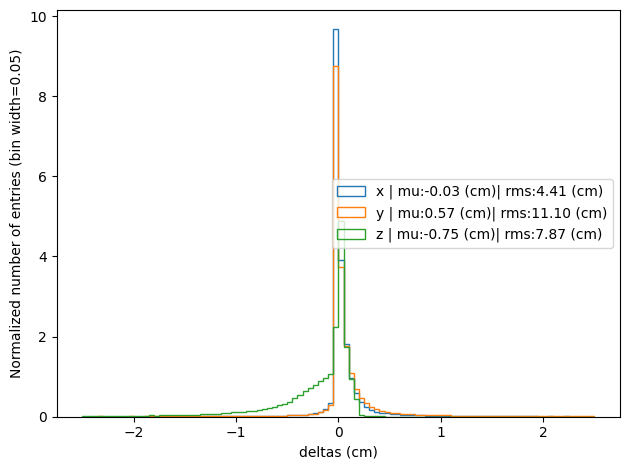

In [218]:
test_sce(data, False)

In [219]:
corrections = sce_map.get_value_record(mc.recoParticles.beam_calo_pos)

'get_value_record' executed in 41.0346s

In [221]:
vector.add(mc.recoParticles.beam_calo_pos, corrections)

<Array [[], ..., [{x: -30.5, ...}, ..., {...}]] type='102443 * var * {x: fl...'>